# parm@frosst-y to SMIRFF

This notebook provides examples/utility functionality to assist with conversion of parm@frosst or relatives to SMIRFF format. Particularly, Christopher Bayly is generating modified AMBER `frcmod` files where the first entry for each parameter (i.e. `CT-CT-CT`) is replaced by the relevant SMIRKS pattern, for conversion into SMIRFF FFXML format. 

This notebook will:
1. Convert a specified smirks-frcmod file to SMIRFF FFXML
2. Generate (or take in) a set of molecules in OpenEye oemol format
3. Use the SMIRFF `ForceField` class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter.

Bayly will potentially also update the notebook with visualization for 3(b) and 3(c).


**Authors**:
* David L. Mobley (UCI)


In [25]:
# Imports
from __future__ import print_function
from convert_frcmod import *
import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
import openeye.oedepict as oedepict
from IPython.display import display
from smarty.forcefield import *
from smarty.forcefield_utils import get_molecule_parameterIDs
from smarty.utils import *
from smarty.sampler_smirky import *
% matplotlib inline
import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import IPython
import pickle

In [59]:
def depictAtomByIdx(mol_copy, atomIdxList, supH = True, width=900, height=500):
    mol = oechem.OEMol(mol_copy)
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in atomIdxList:
            atomBondSet.AddAtom( atom)
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if (nbrIdx in atomIdxList) and nbrIdx>atom.GetIdx():
                    atomBondSet.AddBond( bond)
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    aroStyle = oedepict.OEHighlightStyle_Color
    aroColor = oechem.OEColor(oechem.OEGrey)
    oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                               oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

In [5]:
def getMolParamIDToAtomIndex( oemol, ff):
    """Take an OEMol and a SMIRFF forcefield object and return a dictionary,
    keyed by parameter ID, where each entry is a tuple of
    ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
    corresponding to that parameter ID and a list of the atom groups in that
    molecule that parameter is applied to.

    Parameters
    ----------
    oemol : OEMol
        OpenEye OEMol with the molecule to investigate.
    ff : ForceField
        SMIRFF ForceField object (obtained from an ffxml via ForceField(ffxml)) containing FF of interest.

    Returns
    -------
    param_usage : dictionary
        Dictionary, keyed by parameter ID, where each entry is a tuple of
        ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
        corresponding to that parameter ID and a list of the atom groups in
        that molecule that parameter is applied to.

    """
    labels = ff.labelMolecules([oemol])
    param_usage = {}
    for mol_entry in range(len(labels)):
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, smirks) in labels[mol_entry][force]:
                if not pid in param_usage:
                    param_usage[pid] = (smirks, [atom_indices])
                else:
                    param_usage[pid][1].append( atom_indices )

    return param_usage

## 1. Convert specified SMIRKS `frcmod` file to SMIRFF FFXML

In [6]:
# Input and output info
#infile = 'example.frcmod' # smirffish frcmod file to convert
infile = 'smirffishFrcmod.parm99Frosst.txt' # smirffish frcmod file to convert
smirffFilename = 'smirff99Frosst'
ffxmlFile = smirffFilename+'.ffxml'
template = 'template.ffxml' # Template FFXML file without parameters (but with remainder of contents)

In [7]:
# Convert
# Already converted
convert_frcmod_to_ffxml( infile, template, ffxmlFile)

In [8]:
# Load SMIRFF FFXML
ff = ForceField(ffxmlFile) # We will use this below to access details of parameters

## 2. Generate or take in a set of molecules in OpenEye OEMol format

Here we will take in the ZINC parm@frosst subset from CCL (which is also packaged with SMARTY) and read all the molecules from it.

In [66]:
# Use utils wrapper functions to find the file and read all of the molecules
#oemols = read_molecules( get_data_filename('molecules/zinc-subset-tripos.mol2.gz'))
molecules = read_molecules("updated_DrugBank.mol2.gz")

# For use later, generate isomeric SMILES for these so we can easily look up molecules by smiles
isosmiles_to_mol = {}
for mol in molecules:
    smi = oechem.OECreateIsoSmiString(mol)
    isosmiles_to_mol[smi] = mol

oemols = [mol for smi, mol in isosmiles_to_mol.items()]
print("After filtering repeated SMILES there are %i molecules" % len(oemols))

Loading molecules from 'updated_DrugBank.mol2.gz'...
6692 molecules read
1.939 s elapsed
After filtering repeated SMILES there are 6546 molecules


## 3. Determine parameter usage in molecules

Here we will use the SMIRFF ForceField class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter. We begin by just loading the SMIRFF forcefield we generated in section 1.

### 3(a). Determine which parameters are used in which molecules

Here we determine which parameters are actually used in which molecules, and make a couple example plots of the frequency of parameter occurrences for some of our example parameters.

In [26]:
# Track time
init_time = time.time()
# label molecules
labels = ff.labelMolecules(oemols, verbose = False)
elapsed = (time.time() - init_time) / 60.0
print("Assigned labels took %.2f minutes" % (elapsed))

Assigned indices for 262 parameters in 9.36 minutes


In [35]:
# organize dictionaries to reference information 
init_time = time.time()
parameters_by_molecule = dict()
parameters_by_ID = dict()
param_ids = set()
param_id_counts = dict()
for idx, mol_dict in enumerate(labels):
    smi = OECreateIsoSmiString(oemols[idx])
    parameters_by_molecule[smi] = dict()
    for force_type, label_set in mol_dict.items():
        for (indices, pid, smirks) in label_set:
            if not parameters_by_molecule[smi].has_key(pid):
                parameters_by_molecule[smi][pid] = list()
            parameters_by_molecule[smi][pid].append(indices)
            
            if not parameters_by_ID.has_key(pid):
                parameters_by_ID[pid] = set()
            parameters_by_ID[pid].add(smi)
            
            param_ids.add(pid)

for pid in param_ids:
    param_id_counts[pid] = 0
    
for smi, pid_dict in parameters_by_molecule.items():
    for pid, ind_list in pid_dict.items():
        param_id_counts[pid] += len(ind_list)
        
# Save data to pickled dictionary so we could load it back in if needed
smirff_dict = 'smirff99Frosst.p'
pickle.dump([parameters_by_molecule, parameters_by_ID, param_ids, param_id_counts], open(smirff_dict,'wb'))   

elapsed = (time.time() - init_time) / 60.0
print("Organizing dictionaries took %.2f minutes" % (elapsed))

Organizing dictionaries took 0.82 minutes


In [36]:
[parameters_by_molecule, parameters_by_ID, param_ids, param_id_counts] = pickle.load(open(smirff_dict,'rb'))

For fun/info, do a quick graph of frequency of occurrence of particular parameters. Here, let's just do bond parameters

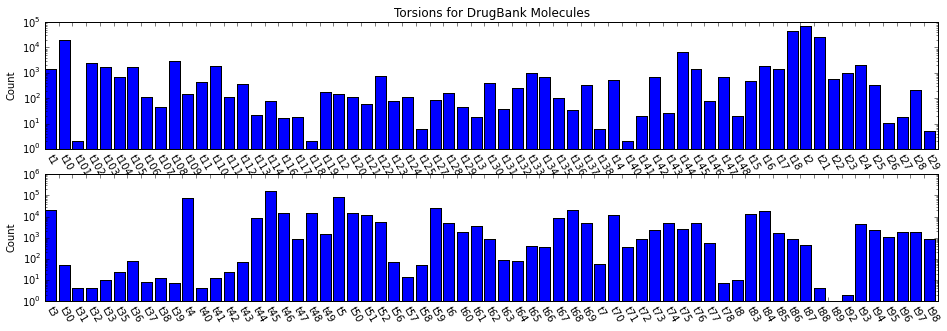

In [37]:
def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort()
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    #print( parm_ids)
    #print( counts_parms)
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()
    

#make_param_histogram(param_id_counts, param_ids, 'n', "VdW for DrugBank Molecules")
#make_param_histogram(param_id_counts, param_ids, 'b', "Bonds for DrugBank Molecules")
#make_param_histogram(param_id_counts, param_ids, 'a', "Angles for DrugBank Molecules")
make_param_histogram(param_id_counts, param_ids, 't', "Torsions for DrugBank Molecules")
#make_param_histogram(param_id_counts, param_ids, 'i', "Impropers for DrugBank Molecules")

### 3(b)-3(c). Determine which molecules do/do not contain selected parameter

Determine which molecules do and do not contain a specified parameter; give access to isomeric smiles and OEMol for each molecule in each case.

In [67]:
# INPUT: Pick what parameter to look at
parameter_id = 't1' 

# For info, get details of that parameter
params = ff.getParameter(paramID=parameter_id)
print("For parameter %s, the relevant parameters are:" % parameter_id)
print(params)

# Find molecules which do/do not use that parameter
mols_with_param = []
mols_wo_param = []
for isosmi in parameters_by_molecule:
    # Store a tuple of (isomeric smiles, oemol) for each
    if parameter_id in parameters_by_molecule[isosmi].keys():
        mols_with_param.append( (isosmi, isosmiles_to_mol[isosmi] ))
    else:
        mols_wo_param.append( (isosmi, isosmiles_to_mol[isosmi] ))

print("\nThere are %s molecules containing that parameter and %s which do not, out of %s.\n" % 
      (len(mols_with_param), len(mols_wo_param), len(isosmiles_to_mol)))

# Print first 10 molecules not containing parameter
print("First 10 molecules not containing that parameter:")
for i in range(10):
    print("   %s" % mols_wo_param[i][0])
# Print first 10 molecules containing parameter
print("\nFirst 10 molecules containing that parameter:")
for i in range(10):
    print("   %s" % mols_with_param[i][0])

For parameter t1, the relevant parameters are:
{'phase1': '180.0', 'smirks': '[*:1]~[*:2]~[*:3]~[*:4]', 'k1': '3.50', 'periodicity1': '2', 'id': 't1', 'idivf1': '4'}

There are 193 molecules containing that parameter and 6353 which do not, out of 6546.

First 10 molecules not containing that parameter:
   c1cc(ccc1c2ccc3c(c2)ccc(c3Cl)O)O
   c1cc(cc(c1)C(=N)N)CN2CCN(CC2=O)S(=O)(=O)c3cc4ccc(cc4s3)Cl
   CCCCCCCCC(=O)OCC(CO)OC(=O)CCC
   Cc1cc(=O)oc2c1cccc2
   CN1CCCC(CC1)n2c(=O)c3ccccc3c(n2)Cc4ccc(cc4)Cl
   CCCCN(CCCC)CC(c1cc(cc2c1-c3ccc(cc3C2=Cc4ccc(cc4)Cl)Cl)Cl)O
   CCOC(=O)C1(CCN(CC1)C)c2ccccc2
   c1cc(cc(c1)Cl)C2=C(C(=O)NC2=O)Nc3ccc(c(c3)C(=O)O)Cl
   Cc1ncc(n1C2CC2)c3ccnc(n3)Nc4ccc(cc4)S(=O)(=O)NC
   CC(Cn1cnc2c1ncnc2N)O

First 10 molecules containing that parameter:
   C[n+]1ccccc1C=NO
   c1ccc(c(c1)CNC(=O)Cn2c(cnc(c2=O)NCC(c3cccc[n+]3[O-])(F)F)Cl)F
   c1ccc(cc1)CC(C[N+](=O)[O-])C(=O)O
   CC1(C(=C(C([N+]1=O)(C)C)c2ccccc2)CSSCC(C(=O)O)N)C
   CC(Cn1ccnn1)(C(C(=O)O)NC=CC=O)[S-](=O)=O
   

In [81]:
def printAtoms(mol, indices):
    #print(indices)
    atoms_by_index = dict()
    charges_by_index = dict()
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        if idx in indices:
            atoms_by_index[idx] = atom
            charge = atom.GetFormalCharge()
            if charge == 0:
                charges_by_index[idx] = ''
            elif charge > -1:
                charges_by_index[idx] = '+%i' % charge
            else:
                charges_by_index[idx] = str(charge)
    atoms = [(atoms_by_index[idx],charges_by_index[idx]) for idx in indices]
    atoms = ['[#%i%s]' % (atom.GetAtomicNum(),charge) for (atom,charge) in atoms]
    print('~'.join(atoms))
    
def DepictMolWithParam(mol, indice_list, supH = False, print_atoms = True):
    for IdxByOccurrence in indice_list:
        if print_atoms:
            printAtoms(mol, IdxByOccurrence)
        display(depictAtomByIdx(mol, IdxByOccurrence, supH = supH))

            

looking at molecule 34
Selected smiles is c1c(c[nH+]cc1C(=O)N)C2C(C(C(O2)COP(=O)([O-])OP(=O)(O)OCC3C(C(C(O3)n4cnc5c4ncnc5N)O)O)O)O
Selected IUPAC name guessed: [[5-(6-aminopurin-9-yl)-3,4-dihydroxy-tetrahydrofuran-2-yl]methoxy-hydroxy-phosphoryl] [5-(5-carbamoylpyridin-1-ium-3-yl)-3,4-dihydroxy-tetrahydrofuran-2-yl]methyl phosphate
mol title and NumAtoms:   71
[#6]~[#7+1]~[#6]~[#1]


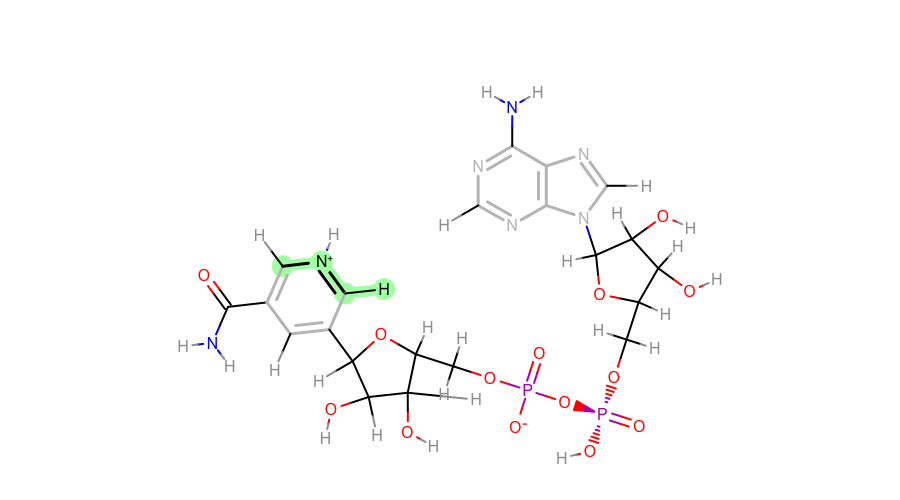

[#6]~[#6]~[#7+1]~[#6]


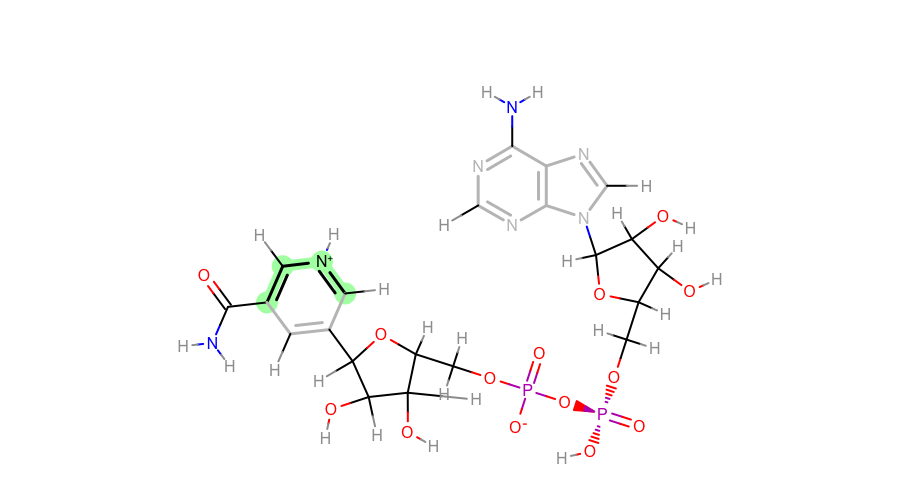

[#6]~[#7+1]~[#6]~[#1]


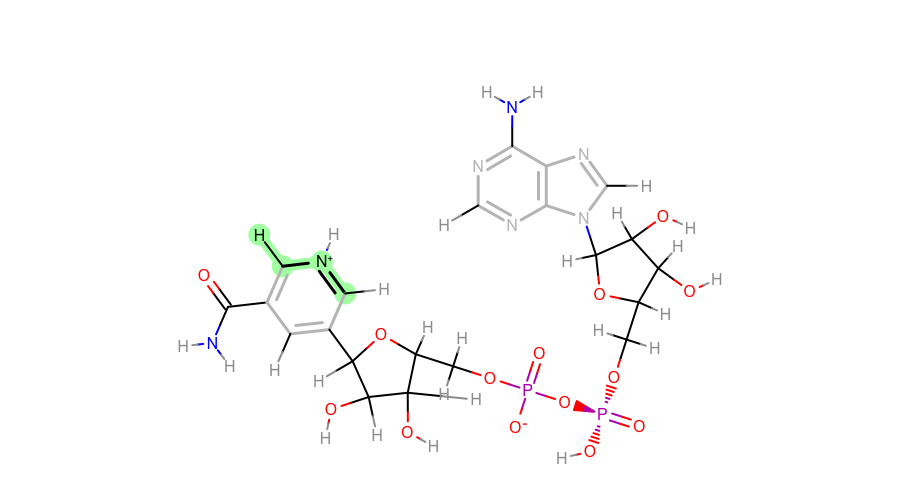

[#6]~[#7+1]~[#6]~[#6]


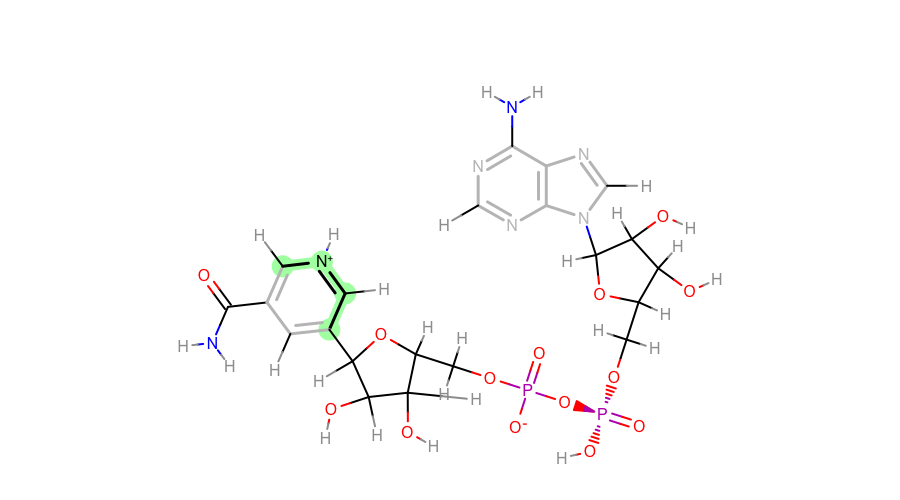

In [103]:
from openeye.oeiupac import *
lowerlimit = 34
upperlimit = 35
limit = len(mols_with_param)
if limit>upperlimit:
    limit = upperlimit
for idx in range(lowerlimit,upperlimit):
    smiles = mols_with_param[idx][0]
    mol = mols_with_param[idx][1]
    OEAddExplicitHydrogens(mol)
    indice_list = parameters_by_molecule[smiles][parameter_id]
    print("looking at molecule %i" % idx)
    print('Selected smiles is %s' % smiles)
    print('Selected IUPAC name guessed: %s' % OECreateIUPACName(mol) )
    print( 'mol title and NumAtoms: ', mol.GetTitle(), mol.NumAtoms() )
    DepictMolWithParam( mol, indice_list, supH = False)
    print()
    print()
    print()
    